### Ordinary least squares Linear Regression. LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256 entries, 0 to 12255
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             12256 non-null  float64
 1   bath            12256 non-null  float64
 2   acre_lot        12256 non-null  float64
 3   zip_code        12256 non-null  float64
 4   house_size      12256 non-null  float64
 5   prev_sold_date  12256 non-null  object 
 6   price           12256 non-null  float64
dtypes: float64(6), object(1)
memory usage: 670.4+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256 entries, 0 to 12255
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             12256 non-null  float64
 1   bath            12256 non-null  float64
 2   acre_lot        12256 non-null  float64
 3   zip_code        12256 non-null  float64
 4   house_size      12256 non-null  float64
 5   price           12256 non-null  float64
 6   prev_sold_year  12256 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 670.4 KB


#### Find the zip code of that has the most houses.

In [5]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

10023.0

#### Find the rows of the zip code that has the most houses.

In [6]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

#### Create common variables to store frequently used values.

In [7]:
features = ["bed","bath","house_size","prev_sold_year","acre_lot"]
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [8]:
X = one_zipcode_df[features]
y = one_zipcode_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [9]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [10]:
def print_more_stuff(title, y_param, predict_param, gscv):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    #find_best_params = gscv.cv_results_["params"].index(gscv.best_params_)
    #mean_fit_time = gscv.cv_results_["mean_fit_time"][find_best_params]
    mean_fit_time = gscv.cv_results_["mean_fit_time"][gscv.best_index_]
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)
    results_dict["mean fit time"].append(mean_fit_time)
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)
    print(title + " Fit Time = " + str(mean_fit_time))

#### Use the selected features with Linear Regression.

In [11]:
lgr = LinearRegression(fit_intercept=False)
lgr_gscv = GridSearchCV(lgr, param_grid={})
lgr_model = lgr_gscv.fit(X_train,y_train)
lgr_predict = lgr_model.predict(X_test)

print_more_stuff("Linear Regression", y_test, lgr_predict, lgr_gscv)

Linear Regression EVS = 0.788089206
Linear Regression MSE = 471,658,109,139.970764
Linear Regression MAE = 517,273.760030
Linear Regression R2 = 0.776519
Linear Regression Fit Time = 0.0049155235290527345


### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [12]:
lgr_rfe = RFE(LinearRegression(), n_features_to_select=num_features_to_select)
lgr_rfe.fit(X, y)
lgr_rfe_selected_features = lgr_rfe.get_support()
print('The selected features are:', list(X.columns[lgr_rfe_selected_features]))

The selected features are: ['bed', 'bath', 'prev_sold_year', 'acre_lot']


In [13]:
X_rfe = one_zipcode_df[list(X.columns[lgr_rfe_selected_features])]
y_rfe = one_zipcode_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [14]:
lgr_rfe = LinearRegression(fit_intercept=False)
lgr_rfe_gscv = GridSearchCV(lgr_rfe, param_grid={})
lgr_rfe_model = lgr_rfe_gscv.fit(X_rfe_train,y_rfe_train)
lgr_rfe_predict = lgr_rfe_model.predict(X_rfe_test)

print_more_stuff("Recursive Feature Elimination", y_rfe_test, lgr_rfe_predict, lgr_rfe_gscv)

Recursive Feature Elimination EVS = 0.721477473
Recursive Feature Elimination MSE = 602,436,849,966.523315
Recursive Feature Elimination MAE = 533,228.997013
Recursive Feature Elimination R2 = 0.714553
Recursive Feature Elimination Fit Time = 0.0017600536346435546


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [15]:
lgr_sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=num_features_to_select)
lgr_sfs.fit(X, y)
lgr_sfs_selected_features = lgr_sfs.get_support()
print('The selected features are:', list(X.columns[lgr_sfs_selected_features]))

The selected features are: ['bed', 'bath', 'house_size', 'prev_sold_year']


In [16]:
X_sfs = one_zipcode_df[list(X.columns[lgr_sfs_selected_features])]
y_sfs = one_zipcode_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [17]:
lgr_sfs = LinearRegression(fit_intercept=False)
lgr_sfs_gscv = GridSearchCV(lgr_sfs, param_grid={})
lgr_sfs_model = lgr_sfs_gscv.fit(X_sfs_train,y_sfs_train)
lgr_sfs_predict = lgr_sfs_model.predict(X_sfs_test)

print_more_stuff("Sequential Feature Selector", y_sfs_test, lgr_sfs_predict, lgr_sfs_gscv)

Sequential Feature Selector EVS = 0.788488878
Sequential Feature Selector MSE = 471,737,273,778.858765
Sequential Feature Selector MAE = 518,182.376911
Sequential Feature Selector R2 = 0.776481
Sequential Feature Selector Fit Time = 0.001495695114135742


### SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute or via an importance_getter callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter.

In [18]:
lgr_sfm = SelectFromModel(estimator=LinearRegression(), threshold=1000)
lgr_sfm.fit(X,y)
lgr_sfm_selected_features = lgr_sfm.get_support()
print('The selected features are:', list(X.columns[lgr_sfm_selected_features]))

The selected features are: ['bed', 'bath', 'house_size', 'prev_sold_year', 'acre_lot']


In [19]:
X_sfm = one_zipcode_df[list(X.columns[lgr_sfm_selected_features])]
y_sfm = one_zipcode_df["price"]
X_sfm_train, X_sfm_test, y_sfm_train, y_sfm_test = train_test_split(X_sfm, y_sfm, test_size=0.3, random_state=random_state_value)

In [20]:
lgr_sfm = LinearRegression(fit_intercept=False)
lgr_sfm_gscv = GridSearchCV(lgr_sfm, param_grid={})
lgr_sfm_model = lgr_sfm_gscv.fit(X_sfm_train,y_sfm_train)
lgr_sfm_predict = lgr_sfm_model.predict(X_sfm_test)

print_more_stuff("Select From Model",y_sfm_test,lgr_sfm_predict,lgr_sfm_gscv)

Select From Model EVS = 0.788089206
Select From Model MSE = 471,658,109,139.970764
Select From Model MAE = 517,273.760030
Select From Model R2 = 0.776519
Select From Model Fit Time = 0.0022457599639892577


#### Use Grid Search CV to find the best Parameters for Polynomial Regression

In [21]:
pipeline_gscv = Pipeline([
    ('poly_features', PolynomialFeatures()), 
    ('poly_model', LinearRegression())
])

pipeline_params={"poly_features__degree":[1,2,3,4,5],"poly_features__include_bias":[False],"poly_model__fit_intercept":[True]}
grid_searchcv = GridSearchCV(pipeline_gscv, param_grid=pipeline_params, cv=5, verbose=1)

In [22]:
grid_searchcv.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly_features', PolynomialFeatures()),
                                       ('poly_model', LinearRegression())]),
             param_grid={'poly_features__degree': [1, 2, 3, 4, 5],
                         'poly_features__include_bias': [False],
                         'poly_model__fit_intercept': [True]},
             verbose=1)

In [23]:
print(f"Best parameters found: {grid_searchcv.best_params_}")

Best parameters found: {'poly_features__degree': 1, 'poly_features__include_bias': False, 'poly_model__fit_intercept': True}


In [24]:
pipeline_params = {}
for what in grid_searchcv.best_params_:
    if pipeline_params.get(what) == None:
        pipeline_params[what] = []
    pipeline_params[what].append(grid_searchcv.best_params_[what])
pipeline_params

{'poly_features__degree': [1],
 'poly_features__include_bias': [False],
 'poly_model__fit_intercept': [True]}

In [25]:
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()), 
    ('poly_model', LinearRegression(fit_intercept=True))
])

poly_grid_searchcv = GridSearchCV(poly_pipeline, param_grid=pipeline_params, cv=5, verbose=1)

poly_grid_model = poly_grid_searchcv.fit(X_train,y_train)
poly_grid_predict = poly_grid_model.predict(X_test)
print_more_stuff("Polynomial Features",y_test,poly_grid_predict, poly_grid_searchcv)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Polynomial Features EVS = 0.789107377
Polynomial Features MSE = 469,319,940,360.606689
Polynomial Features MAE = 513,595.529469
Polynomial Features R2 = 0.777626
Polynomial Features Fit Time = 0.0


#### Graphing the results works best when the data is provided in a DataFrame.

In [26]:
poly_grid_predict_df = pd.DataFrame(poly_grid_predict).reset_index()
poly_grid_predict_df.rename(columns={0: "prediction"},inplace=True)

lgr_predict_df = pd.DataFrame(lgr_predict).reset_index()
lgr_predict_df.rename(columns={0: "prediction"},inplace=True)

lgr_sfm_predict_df = pd.DataFrame(lgr_sfm_predict).reset_index()
lgr_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

lgr_sfs_predict_df = pd.DataFrame(lgr_sfs_predict).reset_index()
lgr_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

lgr_rfe_predict_df = pd.DataFrame(lgr_rfe_predict).reset_index()
lgr_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

#### Scatter Plot graph of the results of Linear Regression, Polynomial Regression, and Test Data.

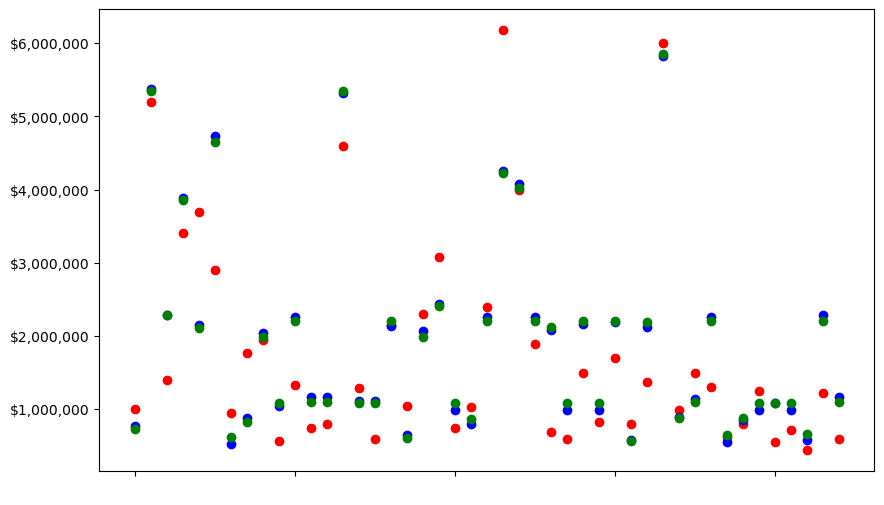

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(poly_grid_predict_df.index,poly_grid_predict_df["prediction"], color="blue")
plt.scatter(lgr_predict_df.index,lgr_predict_df["prediction"], color="green")
plt.show()

#### Scatter Plot graph of the results of Recursive Feature Elimination, Sequential Feature Selection, Select From Model, and Test Data.

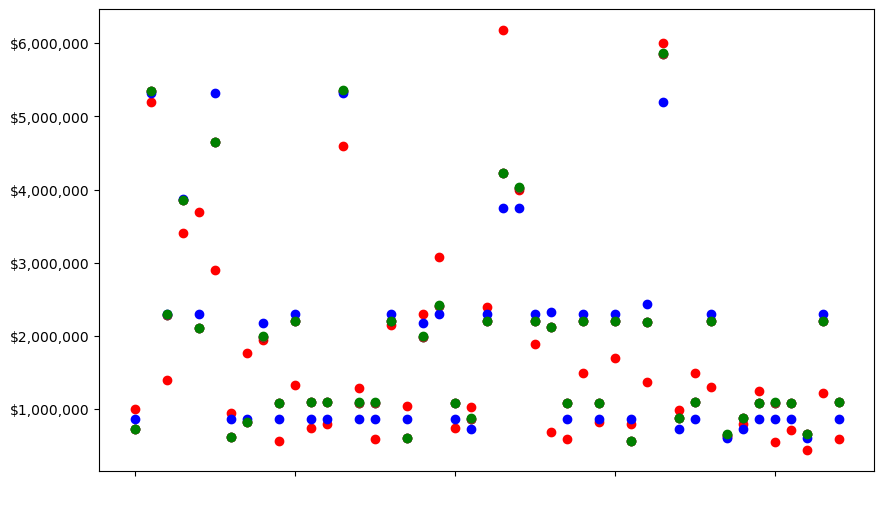

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(lgr_predict_df.index,lgr_predict_df["prediction"], color="black")
plt.scatter(lgr_sfm_predict_df.index,lgr_sfm_predict_df["prediction"], color="brown")
plt.scatter(lgr_rfe_predict_df.index,lgr_rfe_predict_df["prediction"], color="blue")
plt.scatter(lgr_sfs_predict_df.index,lgr_sfs_predict_df["prediction"], color="green")
plt.show()

#### Sort the DataFrames by the Prediction and Price features.

In [29]:
poly_grid_predict_df.sort_values(by='prediction', inplace=True)
poly_grid_predict_df.reset_index(inplace=True)

lgr_predict_df.sort_values(by='prediction', inplace=True)
lgr_predict_df.reset_index(inplace=True)

lgr_sfm_predict_df.sort_values(by='prediction', inplace=True)
lgr_sfm_predict_df.reset_index(inplace=True)

lgr_sfs_predict_df.sort_values(by='prediction', inplace=True)
lgr_sfs_predict_df.reset_index(inplace=True)

lgr_rfe_predict_df.sort_values(by='prediction', inplace=True)
lgr_rfe_predict_df.reset_index(inplace=True)

y_test_df.sort_values(by='price', inplace=True)
y_test_df.reset_index(inplace=True)

#### Line graph of the results of Recursive Feature Elimination, Sequential Feature Selection, Select From Model, Polynomial, and Test Data.

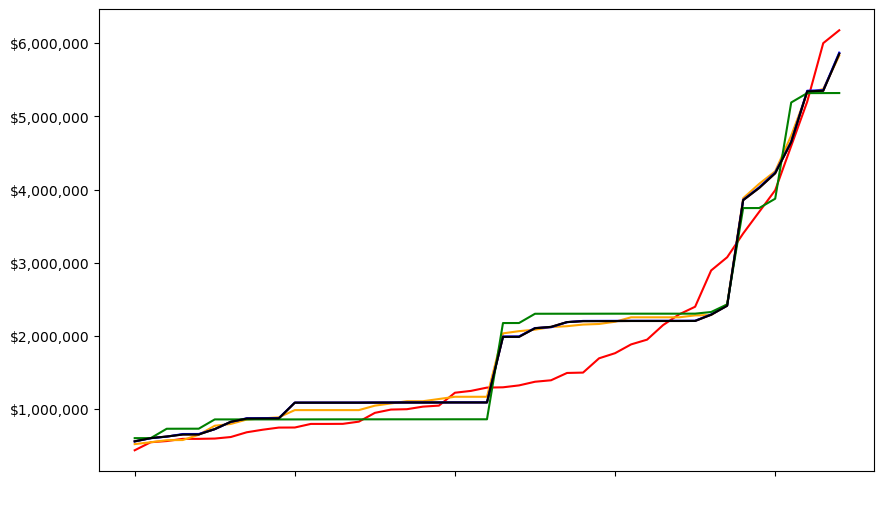

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.plot(y_test_df.index,y_test_df["price"], color="red")
plt.plot(poly_grid_predict_df.index,poly_grid_predict_df["prediction"], color="orange")
plt.plot(lgr_sfm_predict_df.index,lgr_sfm_predict_df["prediction"], color="brown")
plt.plot(lgr_sfs_predict_df.index,lgr_sfs_predict_df["prediction"], color="blue")
plt.plot(lgr_rfe_predict_df.index,lgr_rfe_predict_df["prediction"], color="green")
plt.plot(lgr_predict_df.index,lgr_predict_df["prediction"], color="black")
plt.show()

In [31]:
results_dict

{'model': ['Linear Regression',
  'Recursive Feature Elimination',
  'Sequential Feature Selector',
  'Select From Model',
  'Polynomial Features'],
 'explained variance score': ['0.788089206',
  '0.721477473',
  '0.788488878',
  '0.788089206',
  '0.789107377'],
 'mae score': ['517,273.760030',
  '533,228.997013',
  '518,182.376911',
  '517,273.760030',
  '513,595.529469'],
 'mse score': ['471,658,109,139.970764',
  '602,436,849,966.523315',
  '471,737,273,778.858765',
  '471,658,109,139.970764',
  '469,319,940,360.606689'],
 'r2 score': ['0.776519', '0.714553', '0.776481', '0.776519', '0.777626'],
 'mean fit time': [0.0049155235290527345,
  0.0017600536346435546,
  0.001495695114135742,
  0.0022457599639892577,
  0.0]}

In [32]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Linear Regression,0.788089206,"517,273.760030","471,658,109,139.970764",0.776519,0.004916
Recursive Feature Elimination,0.721477473,"533,228.997013","602,436,849,966.523315",0.714553,0.001760
Sequential Feature Selector,0.788488878,"518,182.376911","471,737,273,778.858765",0.776481,0.001496
Select From Model,0.788089206,"517,273.760030","471,658,109,139.970764",0.776519,0.002246
Polynomial Features,0.789107377,"513,595.529469","469,319,940,360.606689",0.777626,0.000000
